In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Model

from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.initializers import he_normal
from tensorflow.keras import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation

from sklearn.metrics import classification_report

import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

tf.config.list_physical_devices('GPU')

%matplotlib inline

## Data preprocessing

After importing the AddNIST dataset, the x-values are scaled 0-255, so that they can be preprocessed using DenseNet preprocess_input(). This scales the input pixels between 0 and 1, and each channel is normalized with respect to the ImageNet dataset.
The y-values are one-hot encoded to ensure that all classes have the same importance to the model during training.

After the x-values are normalized, they are then reshaped to follow the Keras/Tensorflow *channels_last* data format, and resized to 32x32 to fit the model input shape.

In [2]:
def preprocess_data(x, y):
    
    processed_x = preprocess_input(x)
    
    processed_y = to_categorical(y, 20)
    
    return processed_x, processed_y

In [36]:
x_train = np.load("train_x.npy", allow_pickle=True)
y_train = np.load("train_y.npy", allow_pickle=True)

x_val = np.load("valid_x.npy", allow_pickle=True)
y_val = np.load("valid_y.npy", allow_pickle=True)

x_test = np.load("test_x.npy", allow_pickle=True)
y_test = np.load("test_y.npy", allow_pickle=True)

In [37]:
x_train = (255*(x_train - x_train.min())/x_train.ptp()).astype('uint8')
x_train, y_train = preprocess_data(x_train, y_train)

x_val = (255*(x_val - x_val.min())/x_val.ptp()).astype('uint8')
x_val, y_val = preprocess_data(x_val, y_val)


x_train = np.moveaxis(x_train, 1, -1)
x_train = tf.image.resize(x_train, (32, 32))

x_val = np.moveaxis(x_val, 1, -1)
x_val = tf.image.resize(x_val, (32, 32))

In [5]:
# print(x_train.shape)
# print(x_val.shape)
# print(y_train[1])

# plt.imshow(x_train[1])

## Building, compiling, and training the model

The model is based on the pre-built DenseNet169 model. The top layer was taken off and two layers were added above the pre-trained model. Input and Lambda take the images and resize them to 224x224 fit the DenseNet model. All DenseNet169 layers except the convolutional layers in the final dense block (Dense Block (4)) were frozen, to drastically reduce the training time. Global average pooling was used instead of flattening the output of the pre-built network because flattening would make the next fully connected (FC) layer too computationally expensive, as the output tensor shape would be (None, 81,536). The output is then passed into the first FC layer for feature selection. Batch normalization and dropout are applied to stabilize training and reduce overfitting. The final prediction is achieved using another FC layer, with 20 neurons and the softmax activation function.

This model uses the Adam optimizer and the same categorical cross-entropy loss function as the first model, as these have yielded the highest accuracy. At 10 epochs and a batch size of 64, the model achieves 94% training accuracy, although the validation accuracy is only 77%, meaning that the model is severely overfitting.

In [38]:
initializer = he_normal(seed=32)

input_shape = (224, 224, 3)


model = DenseNet169(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
)

model.trainable = True

for layer in model.layers:
    if 'conv5' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False
        
inp = Input(shape=(32,32,3))
preprocess = Lambda(lambda x: tf.image.resize(x, (224, 224)), name='lambda')(inp)
output = model(inputs=preprocess)

output = GlobalAveragePooling2D()(output)

output = Dense(256, activation='relu', kernel_initializer=initializer)(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)

output = Dense(128, activation='relu', kernel_initializer=initializer)(output)
output = BatchNormalization()(output)

output = Dense(units=20, activation='softmax', kernel_initializer=initializer)(output)

model = Model(inputs=inp, outputs=output)

model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1664)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               426240    
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0   

In [39]:
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [40]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose=1, batch_size=64)

Epoch 1/10
704/704 [==============================] - 412s 569ms/step - loss: 2.5009 - accuracy: 0.2037 - val_loss: 1.8487 - val_accuracy: 0.3637
Epoch 2/10
  9/704 [..............................] - ETA: 5:22 - loss: 1.7404 - accuracy: 0.4138

KeyboardInterrupt: 

## Evaluating the model

The model achieved 94% accuracy while training, 77% accuracy on the validation dataset, and 79% accuracy on the AddNIST testing dataset.
Before getting a prediction, the test x-values are preprocessed the same way as the training data. The test y-values are not one-hot encoded, to generate the classification report.

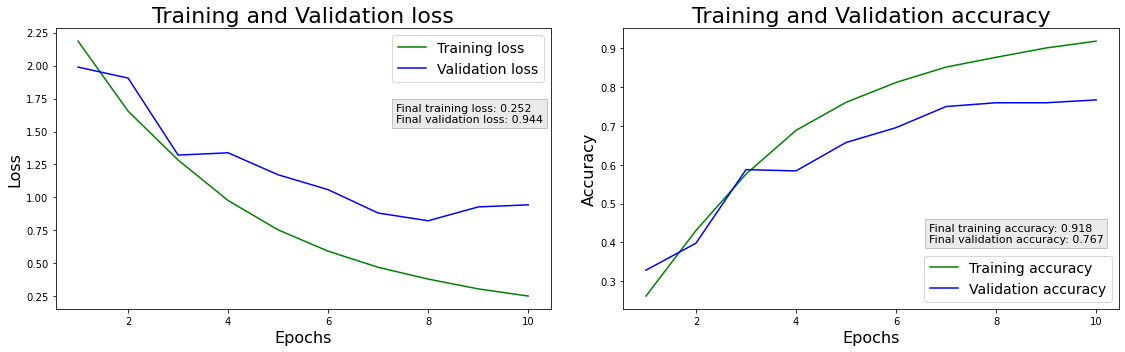

In [24]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


fig, (ax1,ax2) = plt.subplots(1, 2) 
fig.set_size_inches(16, 5)
epochs = range(1,11)

ax1.plot(epochs, train_loss, 'g', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and Validation loss', fontsize = 22)
ax1.set_xlabel('Epochs', fontsize = 16)
ax1.set_ylabel('Loss', fontsize = 16)
ax1.legend(fontsize = 14)

ax2.plot(epochs, train_accuracy, 'g', label='Training accuracy')
ax2.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax2.set_title('Training and Validation accuracy', fontsize = 22)
ax2.set_xlabel('Epochs', fontsize = 16)
ax2.set_ylabel('Accuracy', fontsize = 16)
ax2.legend(fontsize = 14, loc=4)

f_loss = [train_loss[-1], val_loss[-1]]
final_loss = "Final training loss: {}\nFinal validation loss: {}".format(round(f_loss[0], 3), round(f_loss[1], 3))

ax1.text(7.35, 1.57, final_loss, fontsize = 11, 
         bbox = dict(facecolor = '#969696', alpha = 0.2))

f_acc = [train_accuracy[-1], val_accuracy[-1]]
final_accuracy = "Final training accuracy: {}\nFinal validation accuracy: {}".format(round(f_acc[0], 3), round(f_acc[1], 3))

ax2.text(6.65, 0.4, final_accuracy, fontsize = 11, 
         bbox = dict(facecolor = '#969696', alpha = 0.2))

plt.tight_layout()
plt.savefig('Part 2 Training and Validation loss and accuracy.png', dpi=200, format='png', bbox_inches='tight')

In [25]:
'''
Plotting scikit-learn classification report as a heatmap
Source: https://stackoverflow.com/questions/28200786/ 
By Franck Dernoncourt
'''

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(figure_width, figure_height)



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 12
    figure_height = 18
    correct_orientation = True
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

In [30]:
x_test = (255*(x_test - x_test.min())/x_test.ptp()).astype('uint8')
x_test = preprocess_input(x_test)
x_test = np.moveaxis(x_test, 1, -1)
x_test = tf.image.resize(x_test, (32, 32))

In [31]:
prediction = np.argmax(model.predict(x_test), axis=-1)

[0.98, 0.95, 0.97]
[0.88, 0.97, 0.93]
[0.86, 0.95, 0.9]
[0.85, 0.95, 0.9]
[0.82, 0.86, 0.84]
[0.88, 0.83, 0.86]
[0.88, 0.72, 0.79]
[0.8, 0.81, 0.81]
[0.83, 0.74, 0.78]
[0.75, 0.74, 0.74]
[0.66, 0.76, 0.71]
[0.7, 0.67, 0.68]
[0.74, 0.67, 0.7]
[0.73, 0.61, 0.67]
[0.73, 0.59, 0.65]
[0.72, 0.65, 0.68]
[0.62, 0.74, 0.67]
[0.65, 0.69, 0.67]
[0.75, 0.77, 0.76]
[0.72, 0.85, 0.78]
plotMat: [[0.98, 0.95, 0.97], [0.88, 0.97, 0.93], [0.86, 0.95, 0.9], [0.85, 0.95, 0.9], [0.82, 0.86, 0.84], [0.88, 0.83, 0.86], [0.88, 0.72, 0.79], [0.8, 0.81, 0.81], [0.83, 0.74, 0.78], [0.75, 0.74, 0.74], [0.66, 0.76, 0.71], [0.7, 0.67, 0.68], [0.74, 0.67, 0.7], [0.73, 0.61, 0.67], [0.73, 0.59, 0.65], [0.72, 0.65, 0.68], [0.62, 0.74, 0.67], [0.65, 0.69, 0.67], [0.75, 0.77, 0.76], [0.72, 0.85, 0.78]]
support: [395, 423, 454, 504, 447, 544, 497, 466, 527, 534, 531, 544, 536, 506, 519, 507, 477, 518, 532, 539]


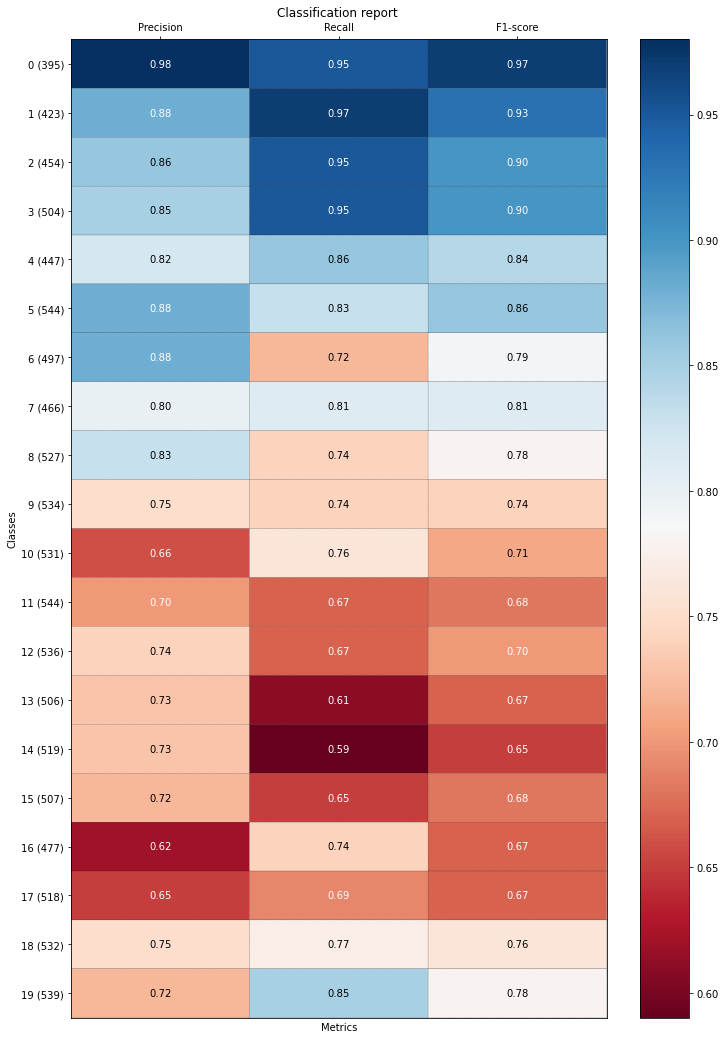

In [32]:
report = classification_report(y_test, prediction)
plot_classification_report(report)
plt.savefig('Part 2 Classification Report.png', dpi=200, format='png', bbox_inches='tight')

In [33]:
print(report)

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       395
           1       0.88      0.97      0.93       423
           2       0.86      0.95      0.90       454
           3       0.85      0.95      0.90       504
           4       0.82      0.86      0.84       447
           5       0.88      0.83      0.86       544
           6       0.88      0.72      0.79       497
           7       0.80      0.81      0.81       466
           8       0.83      0.74      0.78       527
           9       0.75      0.74      0.74       534
          10       0.66      0.76      0.71       531
          11       0.70      0.67      0.68       544
          12       0.74      0.67      0.70       536
          13       0.73      0.61      0.67       506
          14       0.73      0.59      0.65       519
          15       0.72      0.65      0.68       507
          16       0.62      0.74      0.67       477
          17       0.65    